# Exercises: physics-informed neural network

Exercise on the implementation of physics-informed neural network.

Date: 2024

Course: 056936 - SCIENTIFIC COMPUTING TOOLS FOR ADVANCED MATHEMATICAL MODELLING (PAGANI STEFANO) [2023-24].

Example adapted from this [notebook](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link).


Let us consider the problem

\begin{aligned}
  & -\nu \Delta u = -2(x^2+y^2)  \,, \quad (x,y) \in [-1,1] \times [-1,1]\,,\\
  & u(x,-1) = u(x,1) = -x^2 \,, \quad -1 < x < 1\,, \\
  & u(-1,y) = u(1,y) = -y^2 \,, \quad -1 < y < 1\,, \\
\end{aligned}

where $\nu=1$. We consider the PINN framework for solving this PDE.

In [5]:
# import required libraries

import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling


# Solution

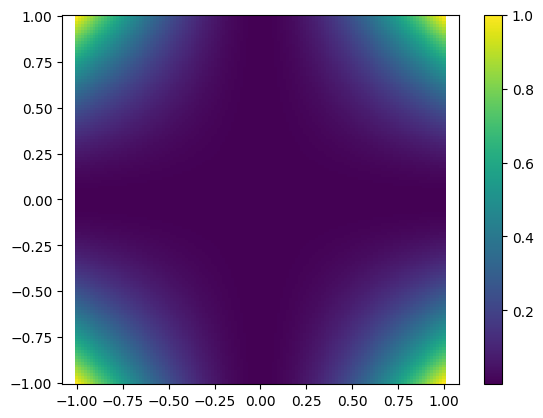

In [32]:
# plot exact solution
nu = 1.0 # diffusion parameter

# define grid for sampling the exact solution
N_h = 128
ux = np.linspace(-1.0,1.0,N_h)
uy = np.linspace (-1.0,1.0,N_h)

# sampling loop:
u_true = np.zeros([N_h,N_h])
for i in range(N_h):
    u_true[:,i] = (ux[i]**2)*(uy**2)

X_plot,Y_plot = np.meshgrid(ux,uy)
plt.pcolor(X_plot, Y_plot, u_true)
plt.axis('equal')
plt.colorbar()

In [33]:
# flatten grid and solution
X,Y = np.meshgrid(ux,uy)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],Y.flatten()[:,None])),dtype=tf.float64)
u_flat = u_true.T.flatten()

In [34]:
np.shape(u_true)

(128, 128)

In [9]:
# PINN loss function
def loss(xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright):
    ulb_pred = PINN(tf.concat([xlb,ylb],1))
    uub_pred = PINN(tf.concat([xub,yub],1))
    uleft_pred = PINN(tf.concat([xleft,yleft],1))
    uright_pred = PINN(tf.concat([xright,yright],1))
    r_pred   = r_PINN(xcl,ycl)

    # loss components
    mse_lb = tf.reduce_mean(tf.pow(ulb_pred-ulb,2))
    mse_ub = tf.reduce_mean(tf.pow(uub_pred-uub,2))
    mse_left = tf.reduce_mean(tf.pow(uleft_pred-uleft,2))
    mse_right = tf.reduce_mean(tf.pow(uright_pred-uright,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return mse_r+mse_lb+mse_ub+mse_left+mse_right #mse_0+mse_r+mse_lb+mse_ub

# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads

In [22]:
# collocation points
Ncl = 2000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)


# Dirichlet boundary condition points (treu point)
Nb = 500
X = lhs(1,Nb)
ylb = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
xlb = -1.0*tf.ones(tf.shape(ylb),dtype=tf.float64)
ulb = (xlb**2)*(ylb**2)
X_lb = tf.concat([xlb,ylb],1)

X = lhs(1,Nb)
yub = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
xub = 1.0*tf.ones(tf.shape(yub),dtype=tf.float64)
uub = (xub**2)*(yub**2)
X_ub = tf.concat([xub,yub],1)

Y = lhs(1,Nb)
xleft = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
yleft = -1.0*tf.ones(tf.shape(xleft),dtype=tf.float64)
uleft = (xleft**2)*(yleft**2)
X_left = tf.concat([xleft,yleft],1)

Y = lhs(1,Nb)
xright = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
yright = 1.0*tf.ones(tf.shape(xright),dtype=tf.float64)
uright = (xright**2)*(yright**2)
X_right = tf.concat([xright,yright],1)

Task 1: Test the accuracy of the reconstruction with respect to the optimization configurations and the number of layers.

In [29]:
# training loop

# initialize new instance of NN
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh', input_shape=(2,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(32, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])

In [30]:
# residual computation based on AD
@tf.function
def r_PINN(x,y):
    u    = PINN(tf.concat([x,y], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_y  = tf.gradients(u,y)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return - u_xx - u_yy + 2.0*( tf.pow(x,2) + tf.pow(y,2) )


# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05,beta_1=0.99)

for iter in range(5000):

  # compute gradients using AD
  loss_value,grads = grad(PINN,xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,PINN.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    PINN_flat = PINN(X_flat)
    err = np.linalg.norm(u_flat-PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))

iter =  200
loss = 0.1713
L2 error: 4.3182e-01
iter =  400
loss = 0.0952
L2 error: 3.0679e-01
iter =  600
loss = 0.0535
L2 error: 2.2863e-01
iter =  800
loss = 0.0404
L2 error: 1.7103e-01
iter =  1000
loss = 0.0299
L2 error: 1.3559e-01
iter =  1200
loss = 0.0071
L2 error: 6.3225e-02
iter =  1400
loss = 0.0022
L2 error: 3.1019e-02
iter =  1600
loss = 0.0010
L2 error: 1.7899e-02
iter =  1800
loss = 0.0039
L2 error: 4.0963e-02
iter =  2000
loss = 0.0008
L2 error: 3.3112e-02
iter =  2200
loss = 0.0005
L2 error: 1.5764e-02
iter =  2400
loss = 0.0003
L2 error: 1.3186e-02
iter =  2600
loss = 0.0003
L2 error: 1.1040e-02
iter =  2800
loss = 0.0006
L2 error: 3.0241e-02
iter =  3000
loss = 0.0004
L2 error: 2.2469e-02
iter =  3200
loss = 0.0003
L2 error: 1.6783e-02
iter =  3400
loss = 0.0011
L2 error: 3.6543e-02
iter =  3600
loss = 0.0003
L2 error: 2.7488e-02
iter =  3800
loss = 0.0002
L2 error: 1.5241e-02
iter =  4000
loss = 0.0002
L2 error: 2.0264e-02
iter =  4200
loss = 0.0002
L2 error: 1.9089e

Text(0.5, 1.0, 'L2 error = 0.0246')

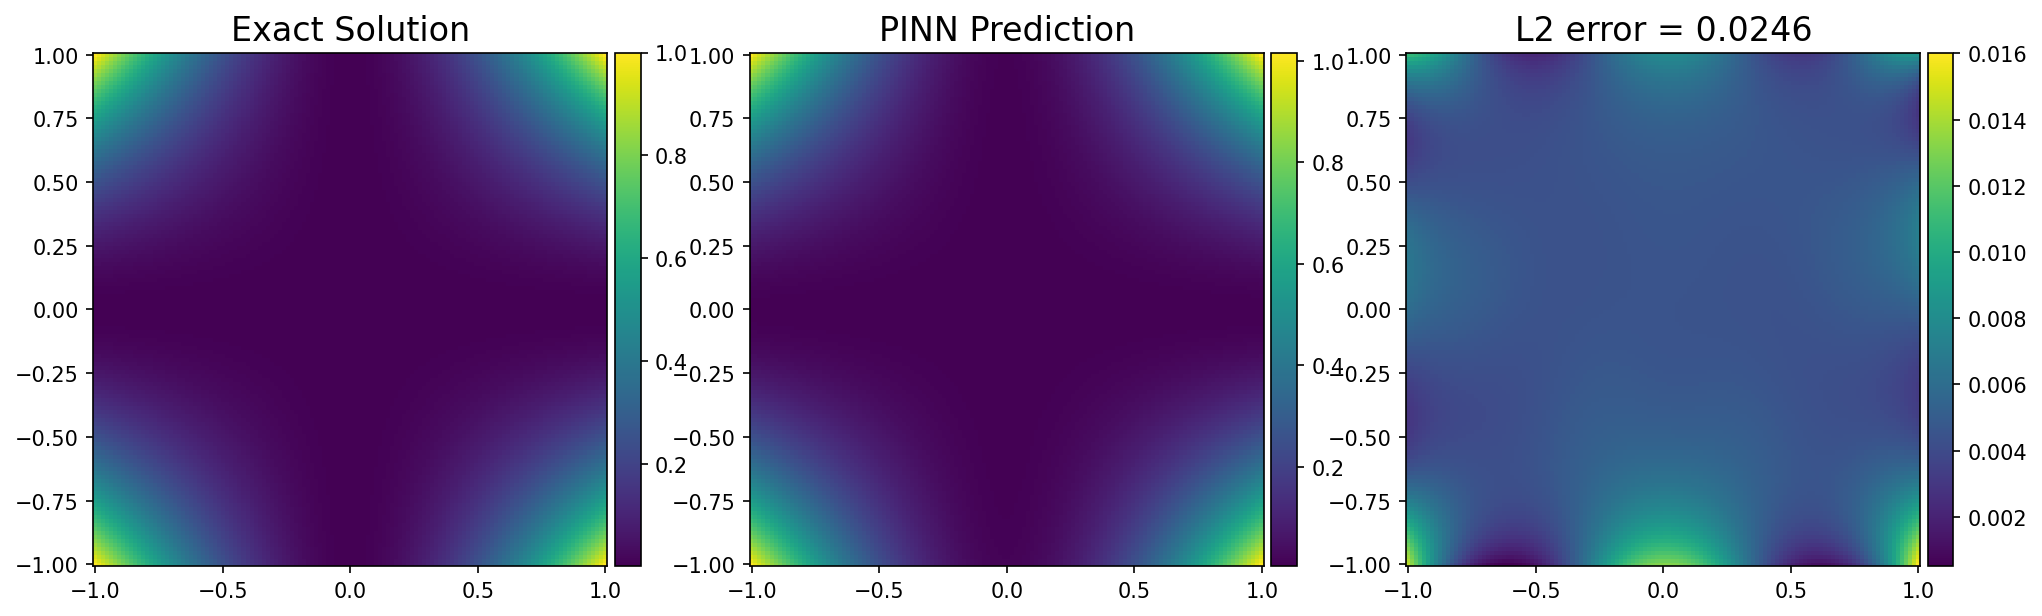

In [31]:
#Display results

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)

Task 2: Re-implement the notebook, considering the case where there are no boundary conditions and measurements are taken only on internal points (chosen randomly). Analyze the accuracy with respect to the number of measurements.

In [40]:
# Internal trainig points
Ndata = 20
X = lhs(2,Ndata)
xdata = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ydata = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_data = tf.concat([xdata,ydata],1)
udata = (xdata**2) * (ydata**2)

# collocation points
Ncl = 2000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [41]:
# PINN loss function
def loss(xcl,ycl,xdata,ydata,udata):
    u_pred = PINN(tf.concat([xdata,ydata],1))
    r_pred   = r_PINN(xcl,ycl)

    # loss components
    mse_internal = tf.reduce_mean(tf.pow(u_pred-udata,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return mse_r+mse_internal #mse_0+mse_r+mse_lb+mse_ub

# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xdata,ydata,udata):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xdata,ydata,udata)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads

In [42]:
# training loop

# initialize new instance of NN
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh', input_shape=(2,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(32, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])

In [43]:
# residual computation based on AD
@tf.function
def r_PINN(x,y):
    u    = PINN(tf.concat([x,y], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_y  = tf.gradients(u,y)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return - u_xx - u_yy + 2.0*( tf.pow(x,2) + tf.pow(y,2) )


# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05,beta_1=0.99)

for iter in range(10000):

  # compute gradients using AD
  loss_value,grads = grad(PINN,xcl,ycl,xdata,ydata,udata)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,PINN.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    PINN_flat = PINN(X_flat)
    err = np.linalg.norm(u_flat-PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))

iter =  200
loss = 0.0195
L2 error: 5.8965e-01
iter =  400
loss = 0.0066
L2 error: 6.3106e-01
iter =  600
loss = 0.0042
L2 error: 6.4408e-01
iter =  800
loss = 0.0036
L2 error: 6.2827e-01
iter =  1000
loss = 0.0030
L2 error: 6.0814e-01
iter =  1200
loss = 0.0027
L2 error: 5.9796e-01
iter =  1400
loss = 0.0022
L2 error: 5.4100e-01
iter =  1600
loss = 0.0017
L2 error: 5.0618e-01
iter =  1800
loss = 0.0014
L2 error: 4.6472e-01
iter =  2000
loss = 0.0012
L2 error: 4.4216e-01
iter =  2200
loss = 0.0011
L2 error: 4.2778e-01
iter =  2400
loss = 0.0009
L2 error: 3.8467e-01
iter =  2600
loss = 0.0008
L2 error: 3.8282e-01
iter =  2800
loss = 0.0009
L2 error: 3.5059e-01
iter =  3000
loss = 0.0008
L2 error: 3.6927e-01
iter =  3200
loss = 0.0008
L2 error: 3.2472e-01
iter =  3400
loss = 0.0008
L2 error: 3.5134e-01
iter =  3600
loss = 0.0007
L2 error: 3.4100e-01
iter =  3800
loss = 0.0006
L2 error: 3.3230e-01
iter =  4000
loss = 0.0007
L2 error: 3.1998e-01
iter =  4200
loss = 0.0004
L2 error: 2.8015e

Text(0.5, 1.0, 'L2 error = 0.2536')

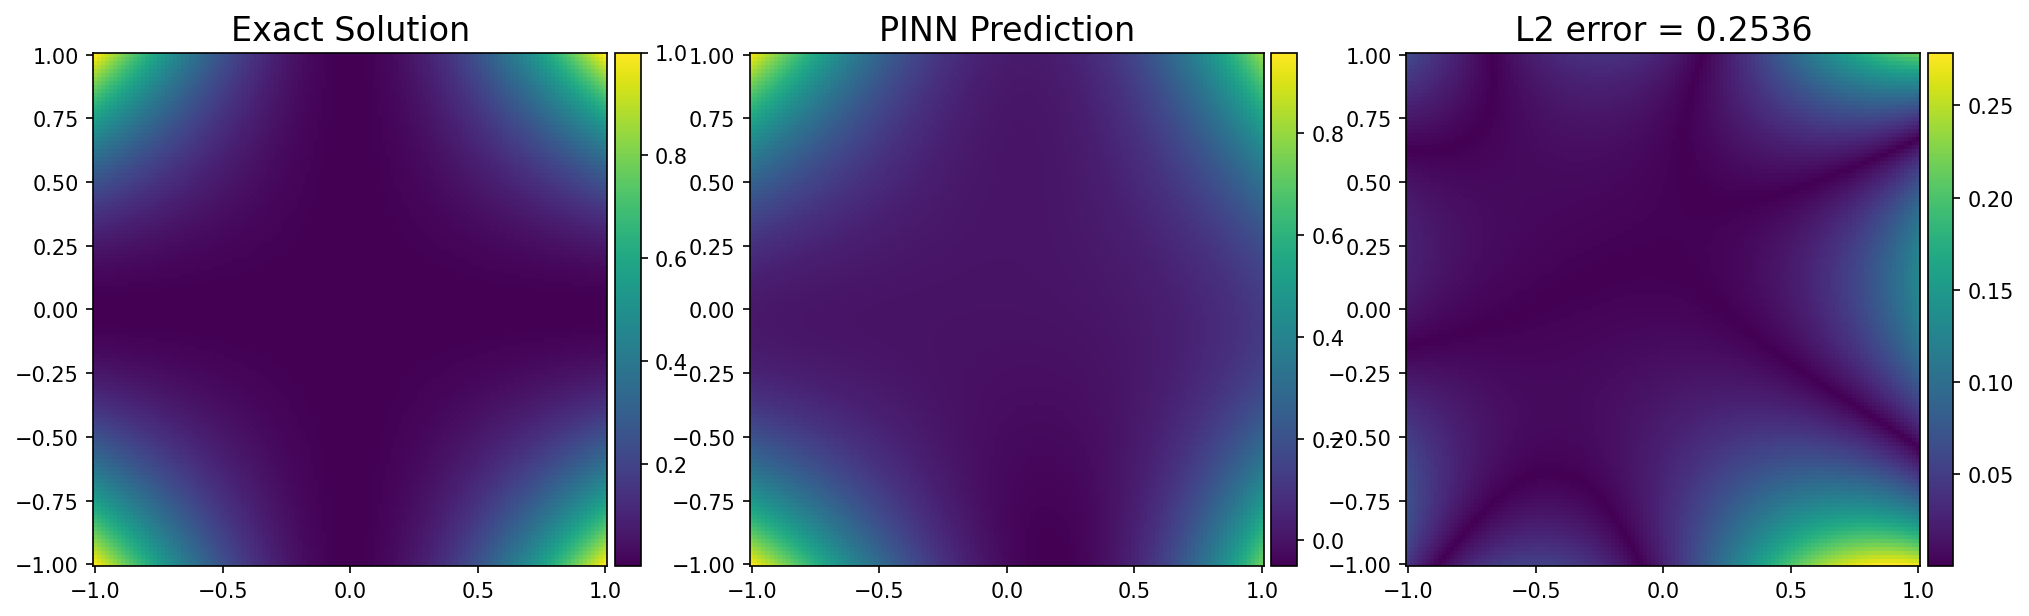

In [39]:
#Display results

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)